# Hybrid recommendation system: Clustering + Conten-based

### Content based algorithm uses similarity between restaurants (review based) to find recommendations
### Clustering uses KMeans Clustering to find members closest to centroid

### Hybrid algorithm will find the most similar restaurant which belongs to the same cluster

### Import necessary modules

In [2]:
import pandas as pd
import time
from IPython.display import display
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from datetime import datetime
from datetime import date
from dateutil import parser
import collections
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from itertools import chain
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from itertools import combinations
from nltk.tokenize import WordPunctTokenizer

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

%matplotlib inline

### Load Data into three DFs: user, review and restaurant info DFs

In [3]:
start = time.time()
restaurant_info = pd.read_csv(r'\\rf3prd431n1\F$\Viraj_work\misc_2\Data_1\restaurant_info.csv', low_memory=False)
user_info = pd.read_csv(r'\\rf3prd431n1\F$\Viraj_work\misc_2\Data_1\user_info_for_restaurants.csv',low_memory=False)
review_info = pd.read_csv(r'\\rf3prd431n1\F$\Viraj_work\misc_2\Data_1\review_info_for_restaurants.csv',low_memory=False)
done = time.time()
elapsed = done-start
print('Reading data took {} seconds'.format(round(elapsed, 2)))

Reading data took 231.35 seconds


### Filter the city and delete rest of the files to clean up memory

In [4]:
city = 'Phoenix'
restaurant_info_city = restaurant_info[restaurant_info.city==city]
review_info_city = review_info[review_info.business_id.isin(restaurant_info_city.business_id)]
user_info_city = user_info[user_info.user_id.isin(review_info_city.user_id)]
#rating_matrix = pd.pivot_table(review_info_city,index=['user_id'],values='stars',columns=['business_id'])

del restaurant_info
del review_info
del user_info

### Get information about final DFs

In [5]:
print('Following is the information about all the relevant datasets for {}\n'.format(city))

print('Restaurant Information\n')
display(restaurant_info_city.info())

print('Review Information\n')
display(review_info_city.info())

print('User Information\n')
display(user_info_city.info())

Following is the information about all the relevant datasets for Phoenix

Restaurant Information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3999 entries, 2 to 59352
Data columns (total 8 columns):
Unnamed: 0      3999 non-null int64
business_id     3999 non-null object
categories      3999 non-null object
city            3999 non-null object
name            3999 non-null object
state           3999 non-null object
review_count    3999 non-null int64
stars           3999 non-null float64
dtypes: float64(1), int64(2), object(5)
memory usage: 281.2+ KB


None

Review Information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 427491 entries, 10 to 4201639
Data columns (total 10 columns):
Unnamed: 0     427491 non-null int64
business_id    427491 non-null object
cool           427491 non-null int64
date           427491 non-null object
funny          427491 non-null int64
review_id      427491 non-null object
stars          427491 non-null int64
text           427491 non-null object
useful         427491 non-null int64
user_id        427491 non-null object
dtypes: int64(5), object(5)
memory usage: 35.9+ MB


None

User Information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155786 entries, 1 to 1148087
Data columns (total 23 columns):
Unnamed: 0            155786 non-null int64
average_stars         155786 non-null float64
compliment_cool       155786 non-null int64
compliment_cute       155786 non-null int64
compliment_funny      155786 non-null int64
compliment_hot        155786 non-null int64
compliment_list       155786 non-null int64
compliment_more       155786 non-null int64
compliment_note       155786 non-null int64
compliment_photos     155786 non-null int64
compliment_plain      155786 non-null int64
compliment_profile    155786 non-null int64
compliment_writer     155786 non-null int64
cool                  155786 non-null int64
elite                 10281 non-null object
fans                  155786 non-null int64
friends               155786 non-null object
funny                 155786 non-null int64
name                  155786 non-null object
review_count          155786 n

None

### Extract information about cuisines

In [6]:
category_series = restaurant_info_city.categories.str.replace('Restaurants','').str.replace(' ', '').str.replace(',', ' ')
category_series.head()

2      Breakfast&Brunch Mexican Tacos Tex-Mex FastFood
19                                            Chinese 
35                                          Food Cafes
56                                   Mexican SushiBars
84                            Pizza Sandwiches Italian
Name: categories, dtype: object

### Represent each reveiw as single list of text - needs to be run only once. Review_in_words is saved so that this does not have to happen every time

In [5]:
tqdm.pandas()
review = review_info_city['text'].progress_apply(lambda x: re.sub('[^a-zA-Z]', ' ', x).lower().split())
ps = PorterStemmer()
review_in_words = review.progress_apply(lambda x: [ps.stem(word) for word in x if not word in set(stopwords.words('english'))])

100%|████████████████████████████████| 427491/427491 [4:56:49<00:00, 24.00it/s]


### 1. Combine reviews each user in a single space separated text string

### 2. Combine reviews for each business in a single space separated text string

In [7]:
start = time.time()
# Define function to convert string to list back to string
def convert_to_string(a):
    try:
        a_1 = a.split(',') # convert string read to list
        a_2 = ' '.join(a_1).replace("'", "") # convert list back to string
        return a_2
    except:
        print(a, type(a))

review_in_words = pd.read_csv(r'\\rf3prd431n1\F$\Viraj_work\misc_2\Data_1\review_in_words.csv', low_memory=False, header=None)
review_in_words.columns = ['index', 'review_text']
review_in_words['review_text'] = review_in_words['review_text'].str.strip("[]")

# apply the convert to string function to the review_text and save it as an extra column in the parent review_info_city
# Dataframe
intermediate_series = review_in_words['review_text'].apply(lambda x: convert_to_string(x))
review_info_city['text_split'] = intermediate_series.values

#userid_df = review_info_city[['user_id','text_split']]
#userid_df = userid_df.groupby('user_id').agg({"text_split": " ".join})

business_df = review_info_city[['business_id', 'text_split']]
business_df = business_df.groupby('business_id').agg({'text_split': ' '.join})
business_df['category_text'] = category_series.values
business_df['text_with_categories'] = business_df['text_split']+' '+business_df['category_text']
display(business_df.head())

done = time.time()
elapsed = done-start
print('Review text conversion and join took {} seconds'.format(round(elapsed, 2)))

,text_split,category_text,text_with_categories
business_id,,,
--g-a85VwrdZJNf0R95GcQ,super fresh food great price ala cart e...,Breakfast&Brunch Mexican Tacos Tex-Mex FastFood,super fresh food great price ala cart e...
-050d_XIor1NpCuWkbIVaQ,good thing go alon practic wait came go...,Chinese,good thing go alon practic wait came go...
-0WegMt6Cy966qlDKhu6jA,guess surpris bar outsid stadium great s...,Food Cafes,guess surpris bar outsid stadium great s...
-0aIra_B6iALlfqAriBSYA,realli good spici chai latt worker kind ...,Mexican SushiBars,realli good spici chai latt worker kind ...
-0tgMGl7D9B10YjSN2ujLA,prob good place drink see live music ma...,Pizza Sandwiches Italian,prob good place drink see live music ma...


Review text conversion and join took 13.32 seconds


### Vectorize the review texts and categories

In [8]:
start = time.time()
#Business id vectorizer
businessid_vectorizer = TfidfVectorizer(tokenizer = WordPunctTokenizer().tokenize, max_features=1000)
businessid_vectors = businessid_vectorizer.fit_transform(business_df['text_with_categories'])
done = time.time()
elapsed = done-start
print('Vectorizing took {} seconds'.format(round(elapsed, 2)))

Vectorizing took 23.54 seconds


### Visualize PCA by converting feature sparse matrix to array

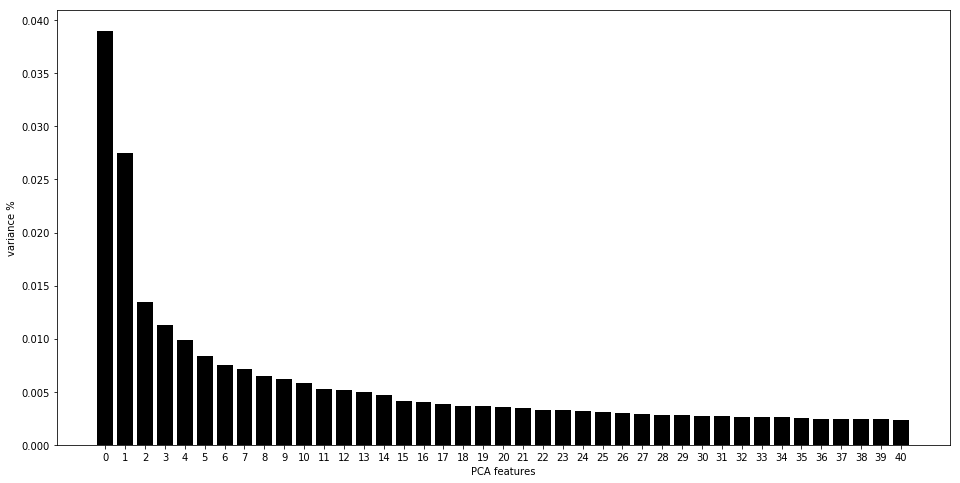

In [9]:
#type(businessid_vectors)
business_std = StandardScaler(with_mean=False).fit_transform(businessid_vectors.toarray())
pca = PCA(n_components=41)
principalComponents = pca.fit_transform(business_std)
features = range(pca.n_components_)
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(16)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()
PCA_components = pd.DataFrame(principalComponents)

### Investigate inertia

Ideally, the way K Means works, is that we want to divide the data into fewest clusters. However, in this case, that is not necessarily the case, since we want to make sure that we get the closest resemblance between restaurants to make the best recommendation.

Hence if we use the elbow method, the choice of n_clusters would be ~3. But in our case, we want to minimize the inertia as much as possible. Hence, we will choose n-clusters where the intertia starts to flatten out. For this purpose, we picked n-clusters to be 6

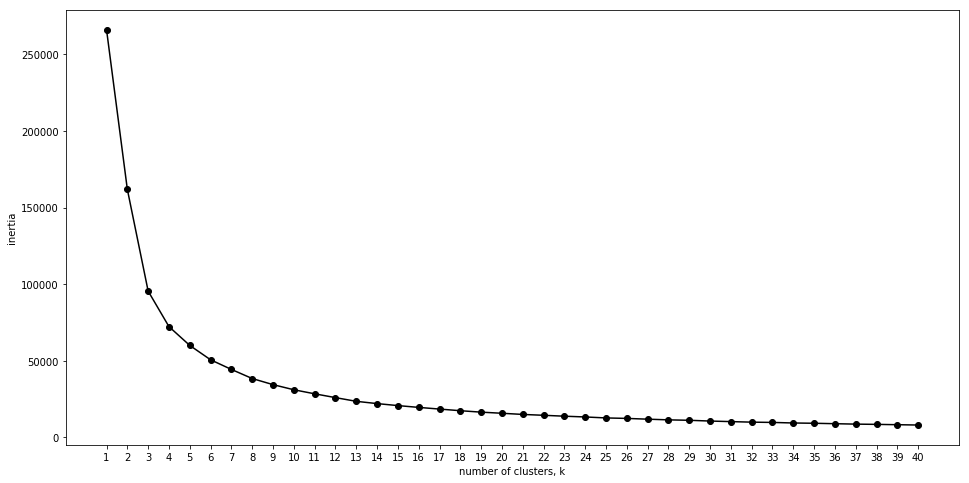

In [10]:
ks = range(1, 41)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:2])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(16) 
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [11]:
from collections import defaultdict
model_final = KMeans(n_clusters=100, random_state=42)
cluster_vals = model_final.fit_predict(PCA_components.iloc[:,:40])
PCA_components_w_clusters = PCA_components.iloc[:,:40]
PCA_components_w_clusters['name'] = restaurant_info_city.name.values
PCA_components_w_clusters['cluster'] = cluster_vals
rest_dict = defaultdict()
for counter in PCA_components_w_clusters.cluster.unique():
    inter_df = PCA_components_w_clusters[PCA_components_w_clusters.cluster==counter]
    d = model_final.transform(inter_df.iloc[:,0:40].to_numpy())[:, counter]
    rest_dict[counter] = np.argsort(d)[::][:]
    rest_dict[counter] = restaurant_info_city.name.iloc[np.argsort(d)[::-1][:]].values

In [12]:
cluster_recommendations_df = PCA_components_w_clusters.cluster.map(rest_dict)
display(cluster_recommendations_df.head(10))

0    [Five Guys, JP's Dog House, Nee House Chinese ...
1    [Subway, Olives Mediterranean Grill, Sam's Gyr...
2    [Tacos Chiwas, Mornin' Moonshine, Sam's Gyros,...
3    [Songbird Coffee & Tea House, 12 East Cafe, Ma...
4    [Bomberos Cafe & Wine Bar, O'Briens Sports Pub...
5    [Long Wong's Famous Wings, Oregano's Pizza Bis...
6    [Birrieria Obregon, Armadillo Grill, O'Briens ...
7    [Chick-fil-A, Nee House Chinese Restaurant, Ch...
8    [Tacos Chiwas, Smashburger, 12 East Cafe, Vals...
9    [Birrieria Obregon, Deemos American Grill, Fiv...
Name: cluster, dtype: object

### Vectorize with categories only

In [13]:
start = time.time()
#Business id vectorizer
businessid_vectorizer = TfidfVectorizer(tokenizer = WordPunctTokenizer().tokenize, max_features=5000)
businessid_vectors = businessid_vectorizer.fit_transform(business_df['text_with_categories'])
done = time.time()
elapsed = done-start
print('Vectorizing took {} seconds'.format(round(elapsed, 2)))

Vectorizing took 23.94 seconds


### Get the cosine similarity matrix using Linear Kernel and extract the best cosine-similaries to a particular restaurant - those are the restaurants which are most similar to subject

In [14]:
cosine_sim = linear_kernel(businessid_vectors, businessid_vectors)
rest_11 = ['rest' + str(i) for i in range(1,1001)]
final_df = pd.DataFrame(columns=rest_11)
for ctr in tqdm(range(len(cosine_sim))):
    sim_scores=[]
    for i,j in enumerate(cosine_sim[ctr]):
        k=restaurant_info_city['stars'].iloc[i]
        sim_scores.append((restaurant_info_city['name'].iloc[i],j,k))
    sim_scores = sorted(sim_scores, key=lambda x: (x[1],x[2]) , reverse=True)  

    a_series = pd.Series(sim_scores[0:1000], index=rest_11)
    final_df = final_df.append(a_series, ignore_index=True)

100%|██████████████████████████████████████| 3999/3999 [29:12<00:00,  1.73it/s]


In [15]:
final_df['name'] = restaurant_info_city.name.values
final_df.set_index('name',inplace=True)
final_df.head(10)

,rest1,rest2,rest3,rest4,rest5,rest6,rest7,rest8,rest9,rest10,...,rest991,rest992,rest993,rest994,rest995,rest996,rest997,rest998,rest999,rest1000
name,,,,,,,,,,,,,,,,,,,,,
Taco Bell,"(Taco Bell, 1.0, 3.0)","(Seed Cafe, 0.7520659501038904, 4.5)","(Stacy's Off Da Hook BBQ and Soul Food, 0.7508...","(Szechwan Palace, 0.7320203793764878, 3.5)","(Morton's The Steakhouse, 0.7311922759810161, ...","(Barro's Pizza, 0.7168385493796043, 3.5)","(Frank's New York Style Deli, 0.71522078680343...","(Tacos Trafi Catering, 0.7149916650693801, 5.0)","(El Sabroso Hot Dog, 0.7139666910781737, 3.5)","(Sauce Pizza & Wine, 0.710440240150113, 4.0)",...,"(Drip Coffee Lounge, 0.3182838535632037, 3.5)","(Steak 44, 0.3182047603702458, 4.5)","(Katz Delicatessen & Sandwich Shop, 0.31816532...","(Flaming Wok, 0.3180882206658734, 4.0)","(Yu's Cafe, 0.31805401067240596, 3.5)","(Canam Realty Group, 0.31795317294894543, 3.0)","(Meatballz, 0.3179461976215755, 2.5)","(Zoes Kitchen, 0.3178571008167459, 3.5)","(Ric's Smokehouse BBQ & Grill, 0.3177267261075...","(Marcelo Delivers, 0.31756868813724337, 4.0)"
Nee House Chinese Restaurant,"(Nee House Chinese Restaurant, 0.9999999999999...","(Huss Brewing Co - Uptown Taproom, 0.947315188...","(Carl's Jr 7081, 0.9201896907392761, 2.0)","(Blue Mesa Tacos, 0.747922219624312, 1.0)","(Santanas Mexican Food, 0.7241726462217801, 3.0)","(27th Ave Bar n Grill, 0.6937693141616695, 3.5)","(Latino Restaurant, 0.6899218052131457, 4.5)","(Subway, 0.6861766508281268, 3.0)","(Santa Madre Taco Shop, 0.6821552926146015, 4.5)","(Oaxaca Restaurant, 0.6743553422823412, 3.0)",...,"(McDonald's, 0.3383258311608151, 2.0)","(Taco Bell, 0.33820876076425693, 2.5)","(Sip Coffee & Beer Garage, 0.3381478858209768,...","(Draw 10 Bar & Grill, 0.3381051321508584, 4.0)","(Red Devil Italian Restaurant & Pizzeria, 0.33...","(Spartan Pita & Gyro, 0.33785386886728364, 4.0)","(Mediterranean Majik Food Truck, 0.33772804094...","(IHOP, 0.33770896309859477, 2.5)","(Rusconi's American Kitchen, 0.337562437548715...","(Jack-In-the Box Drive Thru, 0.337482389554514..."
Vals Getaway DES Cafeteria,"(Vals Getaway DES Cafeteria, 0.999999999999997...","(Little Shanghai, 0.7798795320856357, 3.5)","(Jimmy John's, 0.7710456698885298, 2.5)","(Mariscos El Dorado Sin, 0.7482629483036343, 4.5)","(Little Caesars Pizza, 0.7292973727346442, 2.0)","(Red Devil Italian Restaurant & Pizzeria, 0.72...","(Europa Pastry Cafe, 0.724138407103993, 4.5)","(Dust Cutter, 0.7100599562195216, 4.0)","(PokÃ© Catcher, 0.7066845389681197, 4.5)","(Lucky Kitchen, 0.7057175384775647, 3.0)",...,"(Blue Moon Gentlemen's Club, 0.346067329454294...","(Lunch Time Cafe, 0.34606005197272777, 4.5)","(Plaza Cafe & Grill, 0.34602606397948166, 5.0)","(Ticoz Latin Kitchen, 0.34597470289166754, 4.0)","(Nee House Chinese Restaurant, 0.3458187769928...","(BP's Hotdogs & More, 0.34553344647567646, 5.0)","(Panda Express, 0.34544422301439714, 2.0)","(Pacific Gardens, 0.34518298239897327, 4.0)","(Seasons 52, 0.34491089238284317, 4.0)","(Corduroy, 0.3447144378314858, 4.0)"
Sushi Mocorito,"(Sushi Mocorito, 0.9999999999999991, 3.0)","(Southern Rail, 0.7017054961070657, 3.5)","(Cyprus Grill of Phoenix, 0.5778723924470317, ...","(Livin' Lite Arizona, 0.522219732432157, 4.0)","(Macayo's Mexican Table, 0.516148962535448, 3.0)","(Whataburger Restaurants, 0.4632316749924444, ...","(SpoonZ Cafe, 0.4588495777208934, 3.5)","(Venezia's New York Style Pizzeria, 0.43312670...","(Mid City Kitchen, 0.4310886318488556, 2.5)","(Chi Chi's Tacos, 0.4113673991815871, 5.0)",...,"(Subway, 0.19088367438616455, 2.5)","(Madi G's, 0.19083686926022247, 3.0)","(King Solomon's Pizza, 0.19076074147475014, 4.5)","(Einstein Bros Bagels, 0.19075624123636184, 2.5)","(Burger King, 0.19075449621241797, 2.0)","(Cornish Pasty, 0.1907506325531377, 4.0)","(Vals Getaway DES Cafeteria, 0.190624809729468...","(Cousins Subs, 0.1905808294100806, 2.5)","(Manuel's Mexican Restaurant & Cantina, 0.1905...","(Helpings Cafe, Market and Catering, 0.1905588..."
Oregano's Pi

In [18]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2]
    output = []
    for x in lst3:
        if x not in output:
            output.append(x)
    return output

location = 0
for location in [0,1,2,3,4,5,6,7,8,9,10]:
    print(restaurant_info_city.name.iloc[location])
    content_based_recs_series = final_df.iloc[location]
    content_based_recs_df = pd.DataFrame.from_dict(dict(content_based_recs_series)).T
    content_based_list_df = list(content_based_recs_df[0])
    cluster_based_rec_df = cluster_recommendations_df.iloc[location]
    recommendations = (intersection(content_based_list_df, list(cluster_based_rec_df)))
    display(recommendations)

Taco Bell


['Taco Bell',
 'Songbird Coffee & Tea House',
 'Chick-fil-A',
 'Pizza Hut',
 "Denny's",
 'Birrieria Obregon',
 'Daisy Mountain Coffee Roasters',
 'Subway',
 'Marigold Maison- Paradise Valley',
 'Sushi Mocorito',
 'Deemos American Grill',
 "Sam's Gyros",
 'Mariscos El Dorado Sin',
 "Tarbell's The Tavern",
 '12 East Cafe',
 'Chick Rotisserie & Wine Bar',
 'Pizzeria Bianco',
 'Santanas Mexican Food',
 'Five Guys',
 "Oregano's Pizza Bistro"]

Nee House Chinese Restaurant


['Nee House Chinese Restaurant',
 'Santanas Mexican Food',
 'Subway',
 "Carolina's Mexican Food",
 'Olives Mediterranean Grill',
 'Taco Bell',
 'Birrieria Obregon',
 'Daisy Mountain Coffee Roasters',
 'Smashburger',
 'Pizza Hut',
 'Sushi Mocorito',
 "Denny's",
 'Mariscos El Dorado Sin',
 'Marigold Maison- Paradise Valley',
 'Chick-fil-A',
 "Sam's Gyros",
 '12 East Cafe',
 "Oregano's Pizza Bistro",
 "O'Briens Sports Pub",
 'Pho Bar Central',
 'Deemos American Grill',
 'Krazy 4 Koffee',
 "Francisco's Mexican Food",
 'Vals Getaway DES Cafeteria',
 'Chick Rotisserie & Wine Bar']

Vals Getaway DES Cafeteria


['Vals Getaway DES Cafeteria',
 'Mariscos El Dorado Sin',
 "Sam's Gyros",
 'Subway',
 'Taco Bell',
 'Sushi Mocorito',
 'Pizza Hut',
 "Oregano's Pizza Bistro",
 'Chick-fil-A',
 "O'Briens Sports Pub",
 'Daisy Mountain Coffee Roasters',
 'Birrieria Obregon',
 'Five Guys',
 'Olives Mediterranean Grill',
 'Marigold Maison- Paradise Valley',
 'Santanas Mexican Food',
 'Smashburger',
 "Denny's",
 'Chick Rotisserie & Wine Bar',
 'Pho Bar Central',
 'Squaw Peak Cafe',
 '12 East Cafe',
 'Joeys of Chicago',
 'Katz Delicatessen & Sandwich Shop',
 'Nee House Chinese Restaurant']

Sushi Mocorito


['Sushi Mocorito',
 'Marigold Maison- Paradise Valley',
 'Subway',
 "McDonald's",
 'Olives Mediterranean Grill',
 'Taco Bell',
 'Jack in the Box',
 'Birrieria Obregon',
 'Daisy Mountain Coffee Roasters',
 "Sam's Gyros",
 "Carolina's Mexican Food",
 'Mariscos El Dorado Sin',
 "Oregano's Pizza Bistro",
 'Chick-fil-A',
 'Pizza Hut',
 'The Crepe Club',
 "Denny's",
 'Chick Rotisserie & Wine Bar',
 '12 East Cafe',
 'Smashburger',
 'Pho Bar Central',
 "O'Briens Sports Pub",
 'Pizzeria Bianco',
 "Francisco's Mexican Food",
 'Nee House Chinese Restaurant',
 "Oscar Taylor's",
 'Santanas Mexican Food',
 'Krazy 4 Koffee',
 'Vals Getaway DES Cafeteria']

Oregano's Pizza Bistro


["Oregano's Pizza Bistro",
 "Sam's Gyros",
 'Subway',
 'Mariscos El Dorado Sin',
 'Taco Bell',
 'Sushi Mocorito',
 'Pizza Hut',
 'Birrieria Obregon',
 'Vals Getaway DES Cafeteria',
 'Daisy Mountain Coffee Roasters',
 "O'Briens Sports Pub",
 'Chick-fil-A',
 'Smashburger',
 'Marigold Maison- Paradise Valley',
 'Olives Mediterranean Grill',
 'Chick Rotisserie & Wine Bar',
 "Denny's",
 'Joeys of Chicago',
 'Santanas Mexican Food',
 'Pho Bar Central',
 'Five Guys',
 '12 East Cafe',
 'Squaw Peak Cafe',
 'Pizzeria Bianco',
 'Nee House Chinese Restaurant']

Santanas Mexican Food


['Santanas Mexican Food',
 'Nee House Chinese Restaurant',
 'Taco Bell',
 'Five Guys',
 'Birrieria Obregon',
 'Daisy Mountain Coffee Roasters',
 'Mariscos El Dorado Sin',
 'Pizza Hut',
 'Sushi Mocorito',
 "Denny's",
 "Oregano's Pizza Bistro",
 'Vals Getaway DES Cafeteria',
 '12 East Cafe',
 'Chick Rotisserie & Wine Bar']

Five Guys


['Five Guys',
 'Pizza Hut',
 'Subway',
 'Taco Bell',
 "Denny's",
 'Armadillo Grill',
 'Birrieria Obregon',
 'Chick-fil-A',
 'Mariscos El Dorado Sin',
 'Cranberry Hills Eatery & Catering',
 'Chick Rotisserie & Wine Bar',
 'Marigold Maison- Paradise Valley',
 'Deemos American Grill',
 "Sam's Gyros",
 'Daisy Mountain Coffee Roasters',
 "Oregano's Pizza Bistro",
 "Long Wong's Famous Wings",
 'Olives Mediterranean Grill',
 'Sushi Mocorito']

Pizza Hut


['Pizza Hut',
 'Subway',
 "Denny's",
 "McDonald's",
 'Armadillo Grill',
 'Taco Bell',
 'On Deck Sports Grill',
 'Mariscos El Dorado Sin',
 'Chick Rotisserie & Wine Bar',
 'Cranberry Hills Eatery & Catering',
 'Five Guys',
 "Francisco's Mexican Food",
 'Santanas Mexican Food',
 'Birrieria Obregon',
 'Olives Mediterranean Grill',
 'Tammie Coe Cakes',
 "Long Wong's Famous Wings",
 'Daisy Mountain Coffee Roasters',
 "Oregano's Pizza Bistro",
 'Deemos American Grill',
 "Sam's Gyros",
 'French Grocery',
 'Sushi Mocorito']

Mariscos El Dorado Sin


['Mariscos El Dorado Sin',
 'Taco Bell',
 'Subway',
 'Chick Rotisserie & Wine Bar',
 'Daisy Mountain Coffee Roasters',
 'Birrieria Obregon',
 "Denny's",
 'Marigold Maison- Paradise Valley',
 'Sushi Mocorito',
 'Pizza Hut',
 "Sam's Gyros",
 'Chick-fil-A',
 '12 East Cafe',
 'Cranberry Hills Eatery & Catering',
 'Santanas Mexican Food',
 'Pizzeria Bianco',
 "O'Briens Sports Pub",
 'Smashburger',
 "Oregano's Pizza Bistro",
 'Vals Getaway DES Cafeteria']

12 East Cafe


['12 East Cafe',
 "Denny's",
 'Birrieria Obregon',
 'Taco Bell',
 'Daisy Mountain Coffee Roasters',
 'Pizzeria Bianco',
 'Subway',
 'Sushi Mocorito',
 'Chick-fil-A',
 'Marigold Maison- Paradise Valley',
 'Mariscos El Dorado Sin',
 'Squaw Peak Cafe',
 "Sam's Gyros",
 'Chick Rotisserie & Wine Bar',
 'Pizza Hut',
 'Deemos American Grill',
 'Smashburger',
 "Oregano's Pizza Bistro",
 'Santanas Mexican Food']

Squaw Peak Cafe


['Squaw Peak Cafe',
 'Sushi Mocorito',
 'Taco Bell',
 'Birrieria Obregon',
 'Mariscos El Dorado Sin',
 '12 East Cafe',
 'Pizza Hut',
 "Oregano's Pizza Bistro",
 'Chick Rotisserie & Wine Bar',
 'Vals Getaway DES Cafeteria',
 'Santanas Mexican Food',
 'Nee House Chinese Restaurant']